In [1]:
# interactive figure
%matplotlib widget

# auto reload modules
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import cmocean
import warnings
import gcm_filters
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import matplotlib.gridspec as gridspec
from dask.distributed import LocalCluster, Client
from matplotlib.colors import LinearSegmentedColormap, CenteredNorm, BoundaryNorm
from sys import platform
from xgcm import Grid
from viztool import pcolor_center, pcolor_limits, get_pdf_of_icdf, create_register_cmaps
# from spectrum import Gaussian_filter_2d
# from spectrum import TWODimensional_spec
from mixdiag import double_front_boundary

In [ ]:
if platform == 'linux' or platform == 'linux2':
    data_dir = '/glade/derecho/scratch/zhihuaz/TracerInversion/Output/'
elif platform == 'darwin':
    data_dir = '/Users/zhihua/Documents/Work/Research/Projects/TRACE-SEAS/TracerInversion/Data/'
else:
    print('OS not supported.')

create_register_cmaps()

### Load odata

In [31]:
# cname = 'd11_M003_Ri020_em01_Q001_W000_D000_St0_init-tracer-fluxed'
cname = 'd11_M006_Ri020_em01_Q001_W000_D000_St0_init-tracer-fluxed'

ihr  = 47
itime = int((ihr - 4)*24*3 - 1)

ds = xr.open_dataset(data_dir+cname+'_state.nc', decode_timedelta=True).isel(time=itime, zC=slice(19,None), zF=slice(19,None)).chunk(zC=5)
ds.close()
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (zC: 45, zF: 46, xC: 2000, yF: 1000, xF: 2000, yC: 1000)
Coordinates:
  * zC       (zC) float32 180B -75.6 -73.9 -72.19 ... -4.246 -2.548 -0.8492
  * zF       (zF) float32 184B -76.46 -74.75 -73.05 -71.34 ... -3.397 -1.698 0.0
  * xC       (xC) float32 8kB -3.998e+03 -3.994e+03 ... 3.994e+03 3.998e+03
  * yF       (yF) float32 4kB 0.0 4.0 8.0 12.0 ... 3.988e+03 3.992e+03 3.996e+03
  * xF       (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * yC       (yC) float32 4kB 2.0 6.0 10.0 14.0 ... 3.99e+03 3.994e+03 3.998e+03
    time     timedelta64[ns] 8B 5 days
Data variables:
    v        (zC, yC, xC) float32 360MB dask.array<chunksize=(5, 1000, 2000), meta=np.ndarray>
    c8       (zC, yC, xC) float32 360MB dask.array<chunksize=(5, 1000, 2000), meta=np.ndarray>
    w        (zC, yC, xC) float32 360MB dask.array<chunksize=(5, 1000, 2000), meta=np.ndarray>
    c7       (zC, yC, xC) float32 360MB dask.array<chunksize=(5, 1000, 2000), meta=np.ndarray>
    b        (zC, yC, xC) float32 360MB dask.array<chunksize=(5, 1000, 2000), meta=np.ndarray>
    u        (zC, yC, xC) float32 360MB dask.array<chunksize=(5, 1000, 2000), meta=np.ndarray>
Attributes: (12/80)
    σ_wind:                 0
    Ly:                     4000.0
    init_tracer:            1
    use_Stokes:             0
    n_per_set:              3.0
    save_ckp_interval:      86400.0
    ...                     ...
    tracer_reset_interval:  1
    Ny:                     1000
    output_prefix:          d11_M009_Ri040_em01_Q001_W000_D000_St0_init-trace...
    Oceananigans:           This file was generated using Oceananigans v0.95.12
    RiB₁:                   40.0
    ckp_prefix:             with-tracer-fluxed

In [5]:
uu = ds.u * ds.u
uv = ds.u * ds.v
uw = ds.u * ds.w
vv = ds.v * ds.v
vw = ds.v * ds.w
ww = ds.w * ds.w
wb = ds.w * ds.b
vb = ds.v * ds.b
ub = ds.u * ds.b

uu.name = 'uu'
uv.name = 'uv'
uw.name = 'uw'
vv.name = 'vv'
vw.name = 'vw'
ww.name = 'ww'
wb.name = 'wb'
vb.name = 'vb'
ub.name = 'ub'

dsf = xr.merge([uu, uv, uw, vv, vw, ww, wb, vb ,ub])
# dsf = xr.merge([uu, uv, uw, vv, vw, ww, wb])
dsf = dsf.assign_attrs(ds.attrs)
dsf['xF']   = ds.xF
dsf['yF']   = ds.yF
dsf['zF']   = ds.zF
dsf['time'] = ds.time

In [6]:
filter_taper = gcm_filters.Filter(
    filter_scale=100,
    dx_min=4,
    filter_shape=gcm_filters.FilterShape.TAPER,
    transition_width=np.pi*4,
    grid_type=gcm_filters.GridType.REGULAR,
)

# filter_gaussian = gcm_filters.Filter(
#     filter_scale=100,
#     dx_min=4,
#     filter_shape=gcm_filters.FilterShape.GAUSSIAN,
#     grid_type=gcm_filters.GridType.REGULAR,
# )

dsl = filter_taper.apply(ds, dims=['yC', 'xC'])
# dsh = ds - dsl
dsf = filter_taper.apply(dsf, dims=['yC', 'xC'])

dsf['uu'] = dsf.uu - (dsl.u * dsl.u)
dsf['uv'] = dsf.uv - (dsl.u * dsl.v)
dsf['uw'] = dsf.uw - (dsl.u * dsl.w)
dsf['vv'] = dsf.vv - (dsl.v * dsl.v)
dsf['vw'] = dsf.vw - (dsl.v * dsl.w)
dsf['ww'] = dsf.ww - (dsl.w * dsl.w)
dsf['wb'] = dsf.wb - (dsl.w * dsl.b)
dsf['vb'] = dsf.vb - (dsl.v * dsl.b)
dsf['ub'] = dsf.ub - (dsl.u * dsl.b)

#### Compute energy production terms for fine-scale kinetic energy

$\frac{\partial \mathcal{E}'}{\partial t} + \nabla\cdot\mathcal{J}' = \Pi + \mathcal{B}' - \mathcal{D}'$

In [7]:
periodic_coords = {dim : dict(left=f'{dim}F', center=f'{dim}C') for dim in 'xy'}
bounded_coords = {dim : dict(outer=f'{dim}F', center=f'{dim}C') for dim in 'z'}
coords = {dim : periodic_coords[dim] if tpl=='P' else bounded_coords[dim] for dim, tpl in zip('xyz', 'PPN')}

In [8]:
grid = Grid(dsl, coords=coords)
dxF = dsl.xF.diff('xF').data[0]
dyF = dsl.yF.diff('yF').data[0]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    b_xf = grid.interp(dsl.b, axis='x').transpose(..., 'xF')
    b_yf = grid.interp(dsl.b, axis='y').transpose(..., 'yF')
    u_xf = grid.interp(dsl.u, axis='x').transpose(..., 'xF')
    u_yf = grid.interp(dsl.u, axis='y').transpose(..., 'yF')
    v_xf = grid.interp(dsl.v, axis='x').transpose(..., 'xF')
    v_yf = grid.interp(dsl.v, axis='y').transpose(..., 'yF')
    w_xf = grid.interp(dsl.w, axis='x').transpose(..., 'xF')
    w_yf = grid.interp(dsl.w, axis='y').transpose(..., 'yF')

    wb_xf = grid.interp(dsf.wb, axis='x').transpose(..., 'xF')
    wb_yf = grid.interp(dsf.wb, axis='y').transpose(..., 'yF')
    vb_yf = grid.interp(dsf.vb, axis='y').transpose(..., 'yF')
    ub_xf = grid.interp(dsf.ub, axis='x').transpose(..., 'xF')

    dsl['dbdx'] = grid.diff(b_xf, axis='x') / dxF
    dsl['dbdy'] = grid.diff(b_yf, axis='y') / dyF

    dsl['dudx'] = grid.diff(u_xf, axis='x') / dxF
    dsl['dudy'] = grid.diff(u_yf, axis='y') / dyF

    dsl['dvdx'] = grid.diff(v_xf, axis='x') / dxF
    dsl['dvdy'] = grid.diff(v_yf, axis='y') / dyF

    dsl['dwdx'] = grid.diff(w_xf, axis='x') / dxF
    dsl['dwdy'] = grid.diff(w_yf, axis='y') / dyF

    dsf['dwbdx'] = - grid.diff(wb_xf, axis='x') / dxF
    dsf['dwbdy'] = - grid.diff(wb_yf, axis='y') / dyF
    dsf['bHMX']  = - grid.diff(ub_xf, axis='x') / dxF - grid.diff(vb_yf, axis='y') / dyF

    bHMX_xf = grid.interp(dsf.bHMX, axis='x').transpose(..., 'xF')
    bHMX_yf = grid.interp(dsf.bHMX, axis='y').transpose(..., 'yF')
    dbHMXdx = grid.diff(bHMX_xf, axis='x') / dxF
    dbHMXdy = grid.diff(bHMX_yf, axis='y') / dyF

dsl['ζ']  = dsl.dvdx - dsl.dudy
dsl['δ']  = dsl.dudx + dsl.dvdy
dsl['σₛ'] = dsl.dvdx + dsl.dudy
dsl['σₙ'] = dsl.dudx - dsl.dvdy
dsl['σ']  = np.sqrt(dsl['σₛ']**2 + dsl['σₙ']**2)
dsl['M²'] = np.sqrt(dsl['dbdx']**2 + dsl['dbdy']**2)

In [9]:
dsf['HSP_δ'] = - (dsf.uu + dsf.vv) * dsl['δ']  / 2
dsf['HSP_σ'] = - (dsf.uu - dsf.vv) * dsl['σₙ'] / 2 - dsf.uv * dsl['σₛ']
dsf['HSP']   =    dsf['HSP_σ'] + dsf['HSP_δ']

dsf['HTb_δ'] = - dsl['M²']**2 * dsl['δ'] / 2
dsf['HTb_σ'] = - (dsl.dbdx**2 - dsl.dbdy**2) * dsl['σₙ'] / 2 - dsl.dbdx * dsl.dbdy * dsl['σₛ']
dsf['Tb_HMX'] = dbHMXdx * dsl.dbdx + dbHMXdy * dsl.dbdy

In [10]:
%%time
cluster = LocalCluster(n_workers=64, threads_per_worker=1, memory_limit='2GB', dashboard_address=':8787')
client = Client(cluster)

delayed_nc = dsl.to_netcdf(data_dir + cname + f'_cg_hr{ihr}_filtered.nc', compute=False)
delayed_nc.compute()

CPU times: user 46.7 s, sys: 49.5 s, total: 1min 36s
Wall time: 1min 51s


In [11]:
%%time

delayed_nc = dsf.to_netcdf(data_dir + cname + f'_cg_hr{ihr}_fluxes.nc', compute=False)
delayed_nc.compute()

CPU times: user 1min 33s, sys: 1min 50s, total: 3min 24s
Wall time: 3min 30s


In [12]:
dsl = xr.open_dataset(data_dir + cname + f'_cg_hr{ihr}_filtered.nc', decode_timedelta=True).chunk(xC=200, yC=200)
dsl.close()

dsf = xr.open_dataset(data_dir + cname + f'_cg_hr{ihr}_fluxes.nc', decode_timedelta=True).chunk(xC=200, yC=200)
dsf.close()

In [13]:
grid = Grid(dsl, coords=coords)
dzF = dsl.zF.diff('zF').data

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    b_zf = grid.interp(dsl.b, axis='z', boundary='extend').transpose(..., 'zF')
    u_zf = grid.interp(dsl.u, axis='z', boundary='extend').transpose(..., 'zF')
    v_zf = grid.interp(dsl.v, axis='z', boundary='extend').transpose(..., 'zF')
    dwbdx_zf = grid.interp(dsf.dwbdx, axis='z', boundary='extend').transpose(..., 'zF')
    dwbdy_zf = grid.interp(dsf.dwbdy, axis='z', boundary='extend').transpose(..., 'zF')

    dsl['dbdz'] = grid.diff(b_zf, axis='z') / dzF
    dsl['dudz'] = grid.diff(u_zf, axis='z') / dzF
    dsl['dvdz'] = grid.diff(v_zf, axis='z') / dzF

    dbVMXdx = grid.diff(dwbdx_zf, axis='z') / dzF
    dbVMXdy = grid.diff(dwbdy_zf, axis='z') / dzF

# dsf['VSP_δ'] =   dsf.ww * dsl['δ']
# dsf['VSP_s'] = - dsf.uw * (dsl.dudz + dsl.dwdx) - dsf.vw * (dsl.dvdz + dsl.dwdy)
# dsf['VSP']   =   dsf['VSP_δ'] + dsf['VSP_s']
dsf['VSP'] = - dsf.uw * (dsl.dudz + dsl.dwdx) - dsf.vw * (dsl.dvdz + dsl.dwdy) + dsf.ww * dsl['δ']

dsf['VTb']    = - dsl.dbdz * (dsl.dwdx * dsl.dbdx + dsl.dwdy * dsl.dbdy)
dsf['Tb_VMX'] = dbVMXdx * dsl.dbdx + dbVMXdy * dsl.dbdy

# dsl['bld'] = get_bld_Rib(dsl.b, dsl.u, dsl.v, dsl.dbdz, dsl.zF, dsl.attrs, Ribc=0.3)
# dsl['mld'] = get_mld(dsl.b)

In [14]:
%%time
# cluster = LocalCluster(n_workers=64, threads_per_worker=1, memory_limit='2GB', dashboard_address=':8787')
# client = Client(cluster)

delayed_nc = dsl.to_netcdf(data_dir + cname + f'_cg_hr{ihr}_submeso.nc', compute=False)
delayed_nc.compute()

CPU times: user 34.6 s, sys: 15.6 s, total: 50.2 s
Wall time: 1min 47s


In [15]:
%%time

delayed_nc = dsf.to_netcdf(data_dir + cname + f'_cg_hr{ihr}_FSKE_budgets.nc', compute=False)
delayed_nc.compute()
client.close()

CPU times: user 35.8 s, sys: 16.2 s, total: 51.9 s
Wall time: 1min 52s


### Load processed data

In [4]:
cname = 'd11_M009_Ri040_em01_Q001_W000_D000_St0_init-tracer-fluxed'
ihr = 5

dsl = xr.open_dataset(data_dir + cname + f'_cg_hr{ihr}_submeso.nc', decode_timedelta=True).chunk(zC=15)
dsl.close()

dsf = xr.open_dataset(data_dir + cname + f'_cg_hr{ihr}_FSKE_budgets.nc', decode_timedelta=True).chunk(zC=15)
dsf.close()

In [14]:
dsl

<xarray.Dataset> Size: 8GB
Dimensions:  (zC: 45, zF: 46, xC: 2000, yF: 1000, xF: 2000, yC: 1000)
Coordinates:
  * zC       (zC) float32 180B -75.6 -73.9 -72.19 ... -4.246 -2.548 -0.8492
  * zF       (zF) float32 184B -76.46 -74.75 -73.05 -71.34 ... -3.397 -1.698 0.0
  * xC       (xC) float32 8kB -3.998 -3.994 -3.99 -3.986 ... 3.99 3.994 3.998
  * yF       (yF) float32 4kB 0.0 4.0 8.0 12.0 ... 3.988e+03 3.992e+03 3.996e+03
  * xF       (xF) float32 8kB -4e+03 -3.996e+03 ... 3.992e+03 3.996e+03
  * yC       (yC) float32 4kB 0.002 0.006 0.01 0.014 ... 3.986 3.99 3.994 3.998
    time     timedelta64[ns] 8B ...
Data variables: (12/25)
    v        (zC, yC, xC) float32 360MB dask.array<chunksize=(15, 1000, 2000), meta=np.ndarray>
    c8       (zC, yC, xC) float32 360MB dask.array<chunksize=(15, 1000, 2000), meta=np.ndarray>
    w        (zC, yC, xC) float32 360MB dask.array<chunksize=(15, 1000, 2000), meta=np.ndarray>
    c7       (zC, yC, xC) float32 360MB dask.array<chunksize=(15, 1000, 2000), meta=np.ndarray>
    b        (zC, yC, xC) float32 360MB dask.array<chunksize=(15, 1000, 2000), meta=np.ndarray>
    u        (zC, yC, xC) float32 360MB dask.array<chunksize=(15, 1000, 2000), meta=np.ndarray>
    ...       ...
    M²       (zC, yC, xC) float32 360MB dask.array<chunksize=(15, 1000, 2000), meta=np.ndarray>
    dbdz     (yC, xC, zC) float32 360MB dask.array<chunksize=(1000, 2000, 15), meta=np.ndarray>
    dudz     (yC, xC, zC) float32 360MB dask.array<chunksize=(1000, 2000, 15), meta=np.ndarray>
    dvdz     (yC, xC, zC) float32 360MB dask.array<chunksize=(1000, 2000, 15), meta=np.ndarray>
    bld      (yC, xC) float64 16MB dask.array<chunksize=(1000, 2000), meta=np.ndarray>
    mld      (yC, xC) float64 16MB dask.array<chunksize=(1000, 2000), meta=np.ndarray>
Attributes: (12/80)
    σ_wind:                 0
    Ly:                     4000.0
    init_tracer:            1
    use_Stokes:             0
    n_per_set:              3.0
    save_ckp_interval:      86400.0
    ...                     ...
    tracer_reset_interval:  1
    Ny:                     1000
    output_prefix:          d11_M009_Ri040_em01_Q001_W000_D000_St0_init-trace...
    Oceananigans:           This file was generated using Oceananigans v0.95.12
    RiB₁:                   40.0
    ckp_prefix:             with-tracer-fluxed

In [5]:
# Convert horizontal coordinates for cell center to km
# ds['xC']  =  ds.xC/1e3
# ds['yC']  =  ds.yC/1e3
dsl['xC'] = dsl.xC/1e3
dsl['yC'] = dsl.yC/1e3
# dsh['xC'] = dsh.xC/1e3
# dsh['yC'] = dsh.yC/1e3
dsf['xC'] = dsf.xC/1e3
dsf['yC'] = dsf.yC/1e3

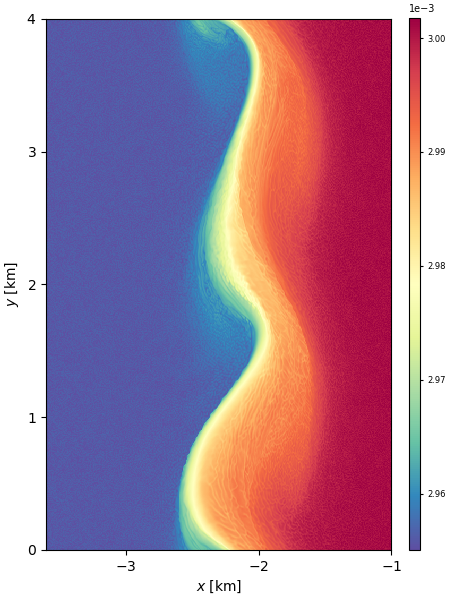

In [11]:
plt.close()
# plt.figure(figsize=(12, 6), constrained_layout=True)
plt.figure(figsize=(4.5, 6), constrained_layout=True)

# pcm,_ = pcolor_center(ds.v.sel(zC=-5, method='nearest'), plt.gca(), cmap='RdBu_r')
pcm,_ = pcolor_limits(ds.b.sel(zC=-0, method='nearest'), plt.gca(), cmap='Spectral_r')
# pcm,_ = pcolor_center(dsl['SS'].isel(zC=iz), plt.gca(), cmap='RdBu_r')#, smag=6)

# pcm,_ = pcolor_limits(np.abs(dsl['w'].isel(zC=iz)), plt.gca(), cmap='binary', clim=[0,3.3e-4])
# pcm,_ = pcolor_center(ds['w'].sel(zC=-10, method='nearest'), plt.gca(), cmap='binary_r', smag=3.3e-3)
# pcm,_ = pcolor_center(dsh['w'].sel(zC=-40, method='nearest'), plt.gca(), cmap=cmapw, smag=1.8e-3)
# pcm,_ = pcolor_center(dsh['w'].isel(zC=iz).where(dsh['w'].isel(zC=iz)<0), plt.gca(), cmap=cmapw, smag=3.3e-4)
# pcm,_ = pcolor_limits(np.abs(dsh['w'].isel(zC=iz)), plt.gca(), cmap='binary', clim=[0, 3.3e-3])
# cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=0.8, aspect=50, pad=0.02, extend='min')

# pcm,_ = pcolor_center(dsl_wp.isel(zC=iz)*dsl_c7p.isel(zC=iz), plt.gca(), cmap='RdBu_r', smag=3e-5)
# cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=0.8, aspect=50, pad=0.02, extend='both')

# pcm,_ = pcolor_limits(dsl['M²'].isel(zC=iz)/dsl.attrs['M²'], plt.gca(), cmap='Purples', clim=[0, 3])
# plt.contour(dsl.xC, dsl.yC, dsl['M²'].sel(zC=-60, method='nearest'), [0.2], colors='g', linewidths=0.5)

# pcm,_ = pcolor_center(dsl['ζ'].isel(zC=-1)/ds.f, plt.gca(), cmap='cmo.curl', smag=4)
# pcm,_ = pcolor_limits(dsl['σ'].isel(zC=-1)/ds.f, plt.gca(), cmap='Reds', clim=[0, 4])
# pcm,_ = pcolor_center(dsl['δ'].isel(zC=-1)/ds.f, plt.gca(), cmap='cmo.balance', smag=4)
# pcm,_ = pcolor_center(dsl['σₙ'].isel(zC=-1)/ds.f, plt.gca(), cmap='cmo.balance')#, smag=10)
# pcm,_ = pcolor_center(dsl['σₛ'].isel(zC=-1)/ds.f, plt.gca(), cmap='cmo.balance')#, smag=10)
# pcm,_ = pcolor_limits(dsl['M²'].isel(zC=-1)/ds.f**2, plt.gca(), cmap='Purples')#, smag=10)

# pcm,_ = pcolor_limits(ds.c8.sel(zC=-15, method='nearest'), plt.gca(), cmap=plt.get_cmap('Spectral_r', 10), clim=[0, 1])
# pcm,_ = pcolor_limits(ds.c8ui, plt.gca(), cmap=plt.get_cmap('c', 20), clim=[0,4e1])
# pcm,_ = pcolor_limits(ds.c8li, plt.gca(), cmap=plt.get_cmap('c', 20), clim=[0,4e1])

# pcm,_ = pcolor_limits(dsh.tke.sel(zC=-10, method='nearest'), plt.gca(), cmap=plt.get_cmap('Reds', 20))
# pcm,_ = pcolor_center((dsh.w**2).sel(zC=-10, method='nearest'), plt.gca(), cmap=plt.get_cmap('w_ds', 20))
# pcm,_ = pcolor_limits((dsh.tke).mean('zC'), plt.gca(), cmap=plt.get_cmap('Reds', 20))

# pcm,_ = pcolor_center(dsf.Rwc8.sel(zC=-10, method='nearest'), plt.gca(), cmap=plt.get_cmap('cp_ds', 24), smag=2e-4)
# pcm,_ = pcolor_center(dsf.rwc8.sel(zC=-10, method='nearest'), plt.gca(), cmap=plt.get_cmap('cp_ds', 24), smag=2e-4)
# pcm,_ = pcolor_center(dsf.lwc8.sel(zC=-10, method='nearest'), plt.gca(), cmap=plt.get_cmap('cp_ds', 48), smag=2e-4)

# pcm,_ = pcolor_center(interp_to_zi(dsf.rwc8, -dsl.bld), plt.gca(), cmap=plt.get_cmap('cp_ds', 48), smag=2e-4)
# pcm,_ = pcolor_center(interp_to_zi(dsf.lwc8, -dsl.bld), plt.gca(), cmap=plt.get_cmap('cp_ds', 48), smag=4e-4)
# plt.contour(ds.xC, ds.yC, interp_to_zi(dsf.rwc8, -dsl.bld), levels=np.array([-0.9, -0.6, -0.3])*1e-4, colors='k', linewidths=1)

# pcm,_ = pcolor_limits(-1e-3 * (1 - ds.c8.isel(zC=-1)), plt.gca(), cmap=plt.get_cmap('Blues_r', 25), clim=[-2.5e-4, 0])

# plt.contour(ds.xC, ds.yC, mask_fz, [0.5, 1.5], colors='gray', linewidths=1.5)
# plt.contour(ds.xC, ds.yC, ds['σ'].isel(zC=-1)/ds.f, 10, colors='k', linewidths=0.2)
# plt.contour(dsl.xC, dsl.yC, ds.c7.sel(zC=-40, method='nearest').where(mask_fz==1), np.arange(0.1, 1, 0.1), cmap='turbo', linewidths=1)
# plt.axhline(0.63, c='k', ls='--')

cbar = plt.colorbar(pcm, ax=plt.gca(), location='right', shrink=1, aspect=50, pad=0.02)
cbar.ax.tick_params(labelsize=6, length=2)
# # cbar.ax.locator_params(nbins=6)
cbar.formatter.set_powerlimits((0, 0))
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_fontsize(7)
offset_text.set_horizontalalignment('left')
offset_text.set_verticalalignment('bottom')
offset_text.set_position((0, 1))

# cbar.set_label(label=r"$w'c_7'$", size=10)
# cbar.set_label(label=r"$w'$ [m s$^{-1}$]", size=10)
# cbar.set_label(label=r'$\widetilde{w}$ [m s$^{-1}$]', size=10)
# cbar.set_label(label=r'10 m $w$ [m s$^{-1}$]', size=10)
# cbar.set_label(label=r'Submesoscale $M^2$ / $M_0^2$', size=10)
# cbar.set_label(label=r'Surface strain $\sigma$ / $f$', size=10)
# cbar.set_label(label=r'Surface divergence $\delta$ / $f$', size=10)
# cbar.set_label(label=r'Surface vorticity $\zeta$ / $f$', size=10)
# plt.title(r'$\bar{w}\bar{c}$')
# plt.title(r'$\overline{wc} - \bar{w}\bar{c}$')
# plt.title(r"$\overline{w'c'}$")
# plt.title(r"$\overline{\bar{w}c'}$")
# plt.title(r"$\overline{w'\bar{c}}$")
# plt.title(r"$\overline{\bar{w}\bar{c}} - \bar{w}\bar{c}$")
plt.gca().set_aspect('equal')
plt.gca().set_yticks(np.linspace(0,4,5))
plt.xlabel(r'$x$ [km]')
plt.ylabel(r'$y$ [km]');
# plt.gca().set_yticks(np.linspace(0,4,9))
plt.gca().set_xticks(np.linspace(-4,4,9));
plt.xlim(-3.6, -1);
# plt.xlim(1, 3.5);

#### Finescale KE budget

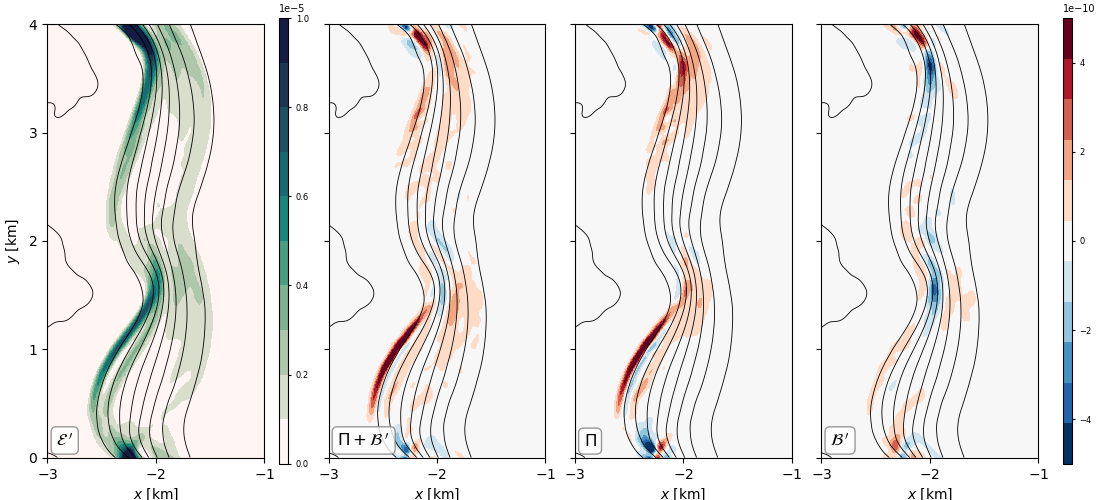

In [28]:
plt.close()
_,ax = plt.subplots(1,4, figsize=(11, 5), constrained_layout=True, sharex=True, sharey=True)

# depth = 5
# pcm0,_ = pcolor_limits((dsf.uu + dsf.vv + dsf.ww).sel(zC=-depth, method='nearest')/2, ax[0], cmap=plt.get_cmap('cmo.tempo',12), clim=[0, 6e-5])
# _,_   = pcolor_center((dsf.HSP + dsf.VSP + dsf.wb).sel(zC=-depth, method='nearest'), ax[1], cmap=plt.get_cmap('RdBu_r',11), smag=3e-9)
# pcm,_   = pcolor_center((dsf.HSP + dsf.VSP).sel(zC=-depth, method='nearest'), ax[2], cmap=plt.get_cmap('RdBu_r',11), smag=3e-9)
# _,_ = pcolor_center(dsf.wb.sel(zC=-depth, method='nearest'), ax[3], cmap=plt.get_cmap('RdBu_r',11), smag=3e-9)

pcm0,_ = pcolor_limits((dsf.uu + dsf.vv + dsf.ww).mean('zC')/2, ax[0], cmap=plt.get_cmap('cmo.tempo',10), clim=[0, 1e-5])
_,_   = pcolor_center((dsf.HSP + dsf.VSP + dsf.wb).mean('zC'), ax[1], cmap=plt.get_cmap('RdBu_r',11), smag=5e-10)
pcm,_   = pcolor_center((dsf.HSP + dsf.VSP).mean('zC'), ax[2], cmap=plt.get_cmap('RdBu_r',11), smag=5e-10)
_,_ = pcolor_center(dsf.wb.mean('zC'), ax[3], cmap=plt.get_cmap('RdBu_r',11), smag=5e-10)


cbar = plt.colorbar(pcm0, ax=ax[0], location='right', shrink=1, aspect=50, pad=0.02)
cbar.ax.tick_params(labelsize=6, length=2)
cbar.formatter.set_powerlimits((0, 0))
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_fontsize(7)
offset_text.set_horizontalalignment('left')
offset_text.set_verticalalignment('bottom')
offset_text.set_position((0, 1))

cbar = plt.colorbar(pcm, ax=ax[1:], location='right', shrink=1, aspect=50, pad=0.02)
cbar.ax.tick_params(labelsize=6, length=2)
cbar.formatter.set_powerlimits((0, 0))
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_fontsize(7)
offset_text.set_horizontalalignment('left')
offset_text.set_verticalalignment('bottom')
offset_text.set_position((0, 1))

txt_strs = [r"$\mathcal{E}\,'$", r"$\Pi + \mathcal{B}\,'$", r'$\Pi$', r"$\mathcal{B}\,'$"]
for j in range(4):
    # ax[j].contour(dsl.xC, dsl.yC, dsl.b.sel(zC=-depth, method='nearest'), 10, colors='k', linewidths=0.6)
    ax[j].contour(dsl.xC, dsl.yC, dsl.b.where(dsl.zC >= -60).mean('zC'), 9, colors='k', linewidths=0.6)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3, -1)
# ax[0].set_xlim(1, 3)
ax[0].set_ylabel(r'$y$ [km]');

#### Horizontal shear production vs. vertical shear production

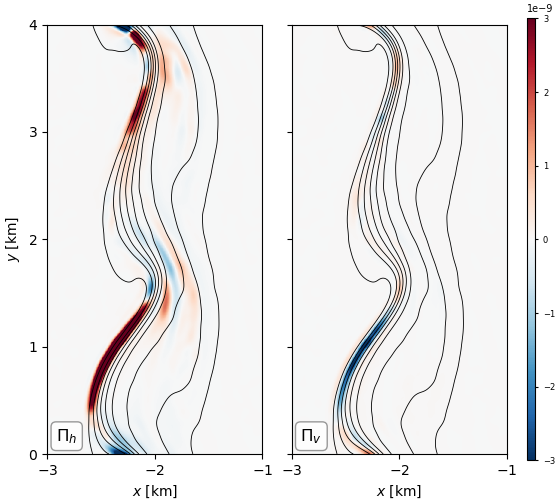

In [27]:
plt.close()
_,ax = plt.subplots(1,2, figsize=(5.6, 5), constrained_layout=True, sharex=True, sharey=True)

depth = 3

_,_   = pcolor_center(dsf['HSP'].sel(zC=-depth, method='nearest'), ax[0], smag=3e-9)
pcm,_ = pcolor_center(dsf['VSP'].sel(zC=-depth, method='nearest'), ax[1], smag=3e-9)

cbar = plt.colorbar(pcm, ax=ax, location='right', shrink=1, aspect=50, pad=0.02)
cbar.ax.tick_params(labelsize=6, length=2)
cbar.formatter.set_powerlimits((0, 0))
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_fontsize(7)
offset_text.set_horizontalalignment('left')
offset_text.set_verticalalignment('bottom')
offset_text.set_position((0, 1))

txt_strs = [r'$\Pi_{h}$', r'$\Pi_{v}$']
for j in range(2):
    ax[j].contour(dsl.xC, dsl.yC, dsl.b.sel(zC=-5, method='nearest'), 10, colors='k', linewidths=0.6)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3, -1)
ax[0].set_ylabel(r'$y$ [km]');

#### Horizontal shear production decomposed

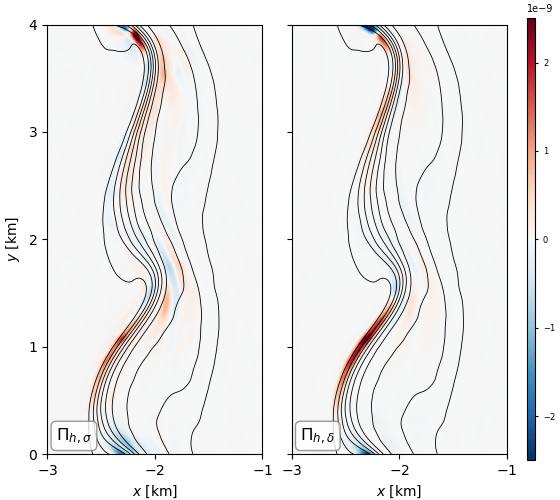

In [38]:
plt.close()
_,ax = plt.subplots(1,2, figsize=(5.6, 5), constrained_layout=True, sharex=True, sharey=True)

_,_   = pcolor_center(dsf['HSP_σ'].sel(zC=-5, method='nearest'), ax[0], smag=2.5e-9)
pcm,_ = pcolor_center(dsf['HSP_δ'].sel(zC=-5, method='nearest'), ax[1], smag=2.5e-9)

cbar = plt.colorbar(pcm, ax=ax, location='right', shrink=1, aspect=50, pad=0.02)
cbar.ax.tick_params(labelsize=6, length=2)
cbar.formatter.set_powerlimits((0, 0))
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_fontsize(7)
offset_text.set_horizontalalignment('left')
offset_text.set_verticalalignment('bottom')
offset_text.set_position((0, 1))

txt_strs = [r'$\Pi_{h,\sigma}$', r'$\Pi_{h,\delta}$']
for j in range(2):
    ax[j].contour(dsl.xC, dsl.yC, dsl.b.sel(zC=-5, method='nearest'), 10, colors='k', linewidths=0.6)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3, -1)
ax[0].set_ylabel(r'$y$ [km]');

#### Vertical shear production decomposed

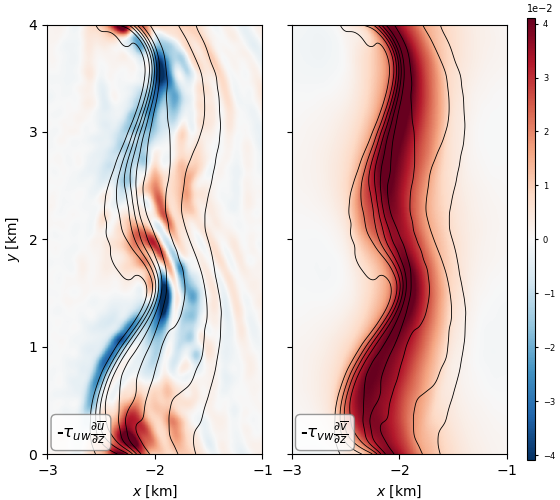

In [45]:
plt.close()
_,ax = plt.subplots(1,2, figsize=(5.6, 5), constrained_layout=True, sharex=True, sharey=True)

depth = 8
# _,_   = pcolor_center(dsf.uw.sel(zC=-depth, method='nearest'), ax[0], smag=9e-7)
# pcm,_ = pcolor_center(dsf.vw.sel(zC=-depth, method='nearest'), ax[1], smag=9e-7)

# _,_   = pcolor_center((- dsf.uw * dsl.dudz).sel(zC=-depth, method='nearest'), ax[0], smag=2.5e-9)
# pcm,_ = pcolor_center((- dsf.vw * dsl.dvdz - dsf.uw * dsl.dwdx - dsf.vw * dsl.dwdy + dsf.ww * dsl['δ']).sel(zC=-depth, method='nearest'), ax[1], smag=2.5e-9)
                      
cbar = plt.colorbar(pcm, ax=ax, location='right', shrink=1, aspect=50, pad=0.02)
cbar.ax.tick_params(labelsize=6, length=2)
cbar.formatter.set_powerlimits((0, 0))
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_fontsize(7)
offset_text.set_horizontalalignment('left')
offset_text.set_verticalalignment('bottom')
offset_text.set_position((0, 1))

# txt_strs = [r'$\Pi_{v,shear}$', r'$\Pi_{v,\delta}$']
txt_strs = [r'-$\tau_{uw}\frac{\partial \overline{u}}{\partial z}$', r'-$\tau_{vw}\frac{\partial \overline{v}}{\partial z}$']
for j in range(2):
    ax[j].contour(dsl.xC, dsl.yC, dsl.b.sel(zC=-depth, method='nearest'), 10, colors='k', linewidths=0.6)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3, -1)
ax[0].set_ylabel(r'$y$ [km]');

#### Horizontal frontogenetic tendency

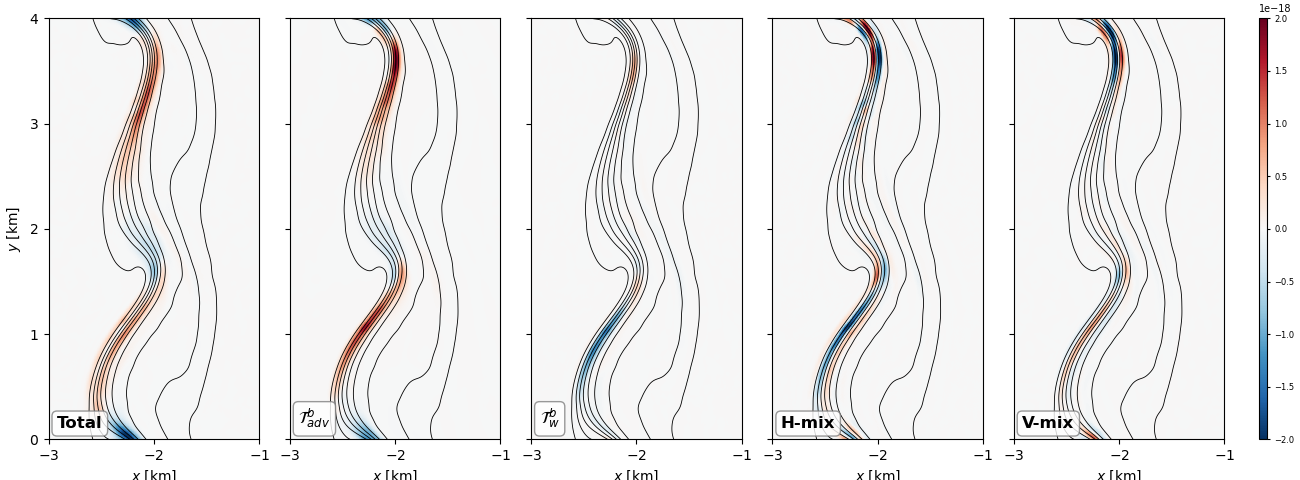

In [48]:
plt.close()
_,ax = plt.subplots(1,5, figsize=(13, 4.8), constrained_layout=True, sharex=True, sharey=True)

pcm,_   = pcolor_center((dsf['HTb_σ'] + dsf['HTb_δ'] + dsf.VTb + dsf.Tb_HMX + dsf.Tb_VMX).sel(zC=-5, method='nearest'), ax[0], smag=2e-18)
_,_ = pcolor_center((dsf['HTb_δ'] + dsf['HTb_δ']).sel(zC=-5, method='nearest'), ax[1], smag=2e-18)
_,_ = pcolor_center(dsf['VTb'].sel(zC=-5, method='nearest'), ax[2], smag=2e-18)
_,_ = pcolor_center(dsf['Tb_HMX'].sel(zC=-5, method='nearest'), ax[3], smag=2e-18)
_,_ = pcolor_center(dsf['Tb_VMX'].sel(zC=-5, method='nearest'), ax[4], smag=2e-18)

cbar = plt.colorbar(pcm, ax=ax, location='right', shrink=1, aspect=50, pad=0.02)
cbar.ax.tick_params(labelsize=6, length=2)
cbar.formatter.set_powerlimits((0, 0))
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_fontsize(7)
offset_text.set_horizontalalignment('left')
offset_text.set_verticalalignment('bottom')
offset_text.set_position((0, 1))

txt_strs = ['Total', r'$\mathcal{T}^b_{adv}$', r'$\mathcal{T}^b_{w}$', 'H-mix', 'V-mix']
for j in range(5):
    ax[j].contour(dsl.xC, dsl.yC, dsl.b.sel(zC=-5, method='nearest'), 10, colors='k', linewidths=0.6)
    ax[j].text(0.04, 0.02, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_aspect('equal')
    ax[j].set_xlabel(r'$x$ [km]')
ax[0].set_yticks(np.linspace(0,4,5))
ax[0].set_xticks(np.linspace(-4,4,9))
ax[0].set_xlim(-3, -1)
ax[0].set_ylabel(r'$y$ [km]');

### Vertical cross-section of finescale KE budgets

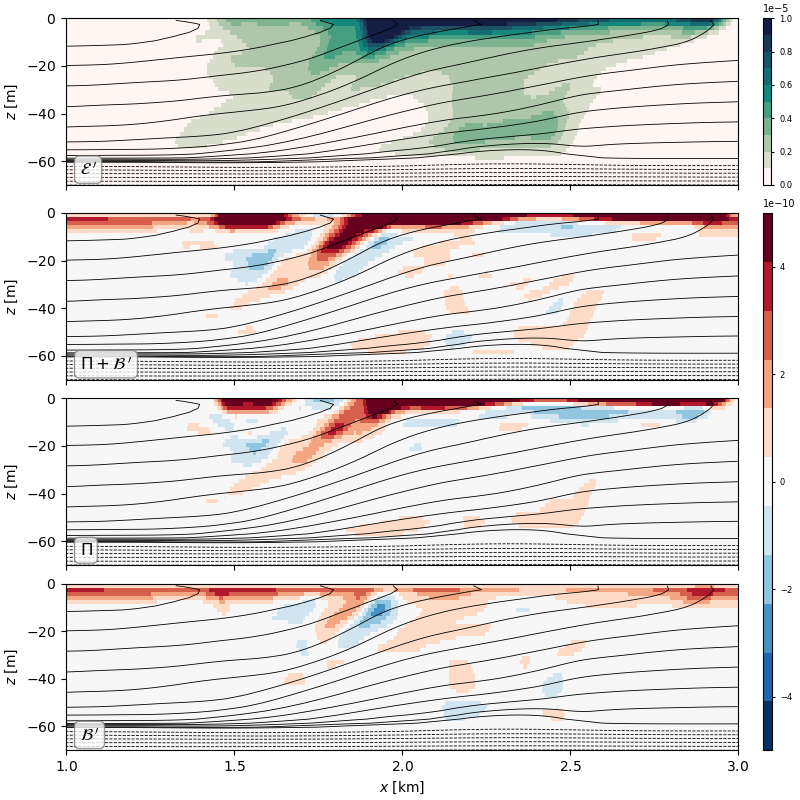

In [25]:
plt.close()
_,ax = plt.subplots(4,1, figsize=(8, 8), constrained_layout=True, sharex=True, sharey=True)

bmld = np.floor(90*dsl.attrs['N₁²'] * 1e6) / 1e2
bsrf = np.floor((60*dsl.attrs['N₀²'] + dsl.Lf*dsl.attrs['M²']) * 1e6) / 1e2 + bmld
delb0 = np.floor((bsrf - bmld)/12 * 1e2) / 1e2
delb1 = 0.06 * (dsl.attrs['M²']/3e-8)**2
blines_upper = np.arange(bmld, bsrf, delb0)*1e-4
blines_lower = np.arange(0, bmld-delb1/2, delb1)*1e-4

# y0 = 3.7
# pcm0,_ = pcolor_limits((dsf.uu + dsf.vv + dsf.ww).sel(yC=y0, method='nearest')/2, ax[0], cmap=plt.get_cmap('cmo.tempo',12), clim=[0, 6e-5])
# _,_   = pcolor_center((dsf.HSP + dsf.VSP + dsf.wb).sel(yC=y0, method='nearest'), ax[1], cmap=plt.get_cmap('RdBu_r',11), smag=3e-9)
# pcm,_   = pcolor_center((dsf.HSP + dsf.VSP).sel(yC=y0, method='nearest'), ax[2], cmap=plt.get_cmap('RdBu_r',11), smag=3e-9)
# _,_ = pcolor_center(dsf.wb.sel(yC=y0, method='nearest'), ax[3], cmap=plt.get_cmap('RdBu_r',11), smag=3e-9)

pcm0,_ = pcolor_limits((dsf.uu + dsf.vv + dsf.ww).mean('yC')/2, ax[0], cmap=plt.get_cmap('cmo.tempo',10), clim=[0, 1e-5])
_,_   = pcolor_center((dsf.HSP + dsf.VSP + dsf.wb).mean('yC'), ax[1], cmap=plt.get_cmap('RdBu_r',11), smag=5e-10)
pcm,_   = pcolor_center((dsf.HSP + dsf.VSP).mean('yC'), ax[2], cmap=plt.get_cmap('RdBu_r',11), smag=5e-10)
_,_ = pcolor_center(dsf.wb.mean('yC'), ax[3], cmap=plt.get_cmap('RdBu_r',11), smag=5e-10)
# _,_ = pcolor_center((dsl.w*dsl.b).mean('yC'), ax[3], cmap=plt.get_cmap('RdBu_r',11))

cbar = plt.colorbar(pcm0, ax=ax[0], location='right', shrink=1, aspect=20, pad=0.02)
cbar.ax.tick_params(labelsize=6, length=2)
cbar.formatter.set_powerlimits((0, 0))
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_fontsize(7)
offset_text.set_horizontalalignment('left')
offset_text.set_verticalalignment('bottom')
offset_text.set_position((0, 1))

cbar = plt.colorbar(pcm, ax=ax[1:], location='right', shrink=1, aspect=60, pad=0.02)
cbar.ax.tick_params(labelsize=6, length=2)
cbar.formatter.set_powerlimits((0, 0))
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_fontsize(7)
offset_text.set_horizontalalignment('left')
offset_text.set_verticalalignment('bottom')
offset_text.set_position((0, 1))

txt_strs = [r"$\mathcal{E}\,'$", r"$\Pi + \mathcal{B}\,'$", r'$\Pi$', r"$\mathcal{B}\,'$"]
for j in range(4):
    # ax[j].contour(dsl.xC, dsl.zC, dsl.b.sel(yC=y0, method='nearest'), blines_upper, colors='k', linewidths=0.6)
    # ax[j].contour(dsl.xC, dsl.zC, dsl.b.sel(yC=y0, method='nearest'), blines_lower, colors='k', linewidths=0.6, linestyles='--')
    ax[j].contour(dsl.xC, dsl.zC, dsl.b.mean('yC'), blines_upper, colors='k', linewidths=0.6)
    ax[j].contour(dsl.xC, dsl.zC, dsl.b.mean('yC'), blines_lower, colors='k', linewidths=0.6, linestyles='--')
    ax[j].text(0.02, 0.04, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_ylabel(r'$z$ [m]')
ax[0].set_xticks(np.linspace(-4,4,17))
ax[0].set_xlim(-3, -1)
# ax[0].set_xlim(1, 3)
ax[3].set_xlabel(r'$x$ [km]')
ax[3].set_ylim(-70, 0);

### Vertical cross-section of frontogenetic tendency terms

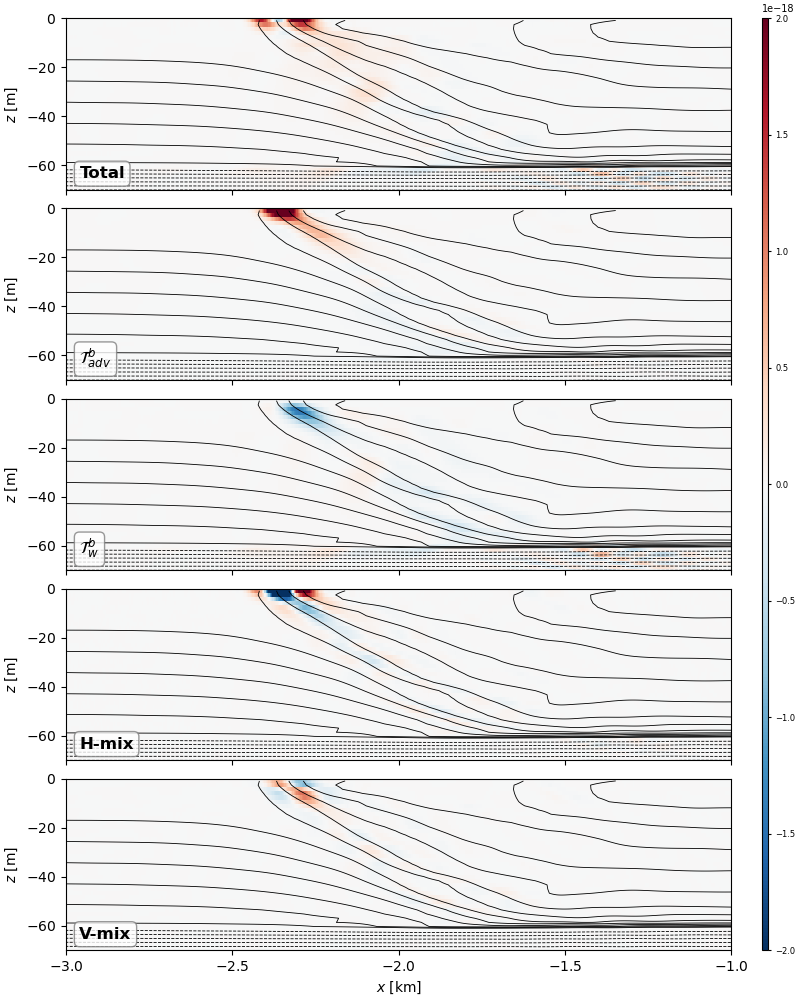

In [21]:
plt.close()
_,ax = plt.subplots(5,1, figsize=(8, 10), constrained_layout=True, sharex=True, sharey=True)

y0 = 1

pcm,_   = pcolor_center((dsf['HTb_σ'] + dsf['HTb_δ'] + dsf.VTb + dsf.Tb_HMX + dsf.Tb_VMX).sel(yC=y0, method='nearest'), ax[0], smag=2e-18)
_,_ = pcolor_center((dsf['HTb_δ'] + dsf['HTb_δ']).sel(yC=y0, method='nearest'), ax[1], smag=2e-18)
_,_ = pcolor_center(dsf['VTb'].sel(yC=y0, method='nearest'), ax[2], smag=2e-18)
_,_ = pcolor_center(dsf['Tb_HMX'].sel(yC=y0, method='nearest'), ax[3], smag=2e-18)
_,_ = pcolor_center(dsf['Tb_VMX'].sel(yC=y0, method='nearest'), ax[4], smag=2e-18)

cbar = plt.colorbar(pcm, ax=ax, location='right', shrink=1, aspect=160, pad=0.02)
cbar.ax.tick_params(labelsize=6, length=2)
cbar.formatter.set_powerlimits((0, 0))
offset_text = cbar.ax.yaxis.get_offset_text()
offset_text.set_fontsize(7)
offset_text.set_horizontalalignment('left')
offset_text.set_verticalalignment('bottom')
offset_text.set_position((0, 1))

txt_strs = ['Total', r'$\mathcal{T}^b_{adv}$', r'$\mathcal{T}^b_{w}$', 'H-mix', 'V-mix']
for j in range(5):
    ax[j].contour(dsl.xC, dsl.zC, dsl.b.sel(yC=y0, method='nearest'), blines_upper, colors='k', linewidths=0.6)
    ax[j].contour(dsl.xC, dsl.zC, dsl.b.sel(yC=y0, method='nearest'), blines_lower, colors='k', linewidths=0.6, linestyles='--')
    ax[j].text(0.02, 0.05, txt_strs[j], ha='left', va='bottom', transform=ax[j].transAxes, fontsize=12, fontweight='bold',
           bbox=dict(facecolor='w', edgecolor='gray', alpha=0.8, boxstyle='round,pad=0.3'))
    ax[j].set_ylabel(r'$z$ [m]')
ax[0].set_xticks(np.linspace(-4,4,17))
ax[0].set_xlim(-3, -1)
ax[4].set_xlabel(r'$x$ [km]')
ax[4].set_ylim(-70, 0);